# Step 1: Filter MEVs from MEGAnE

Given MEGAnE joint callsets, this notebook implements a series of tests for quality control and outputs the MEVs that pass QC to be used in downstream analyses.

In [49]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pysam import VariantFile

import sys
# add path to src module - note this is not a Pythonic solution
sys.path.insert(1, '../') 

from src import parse_vcf

In [50]:
from warnings import filterwarnings
filterwarnings("ignore", category=pd.errors.DtypeWarning)
filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

## Load data

In [51]:
abs_vcf = '/home/AD/rkgadde/L1IP/megane/joint_calling/CZI/CZI_MEA_jointcall.vcf'
ins_vcf = '/home/AD/rkgadde/L1IP/megane/joint_calling/CZI/CZI_MEI_jointcall.vcf'

me_type = 'L1'
rmsk_bed = f'/home/AD/rkgadde/L1IP/RepeatMasker/hg38_noALT.{me_type}.merged.bed'

outdir = '/home/AD/rkgadde/L1IP/mC_data/CZI/type/vars'

In [52]:
abs_vf = VariantFile(abs_vcf)
ins_vf = VariantFile(ins_vcf)

[W::bcf_hrec_check] Invalid tag name: "0START"
[W::bcf_hrec_check] Invalid tag name: "0END"
[W::bcf_hrec_check] Invalid tag name: "0START"
[W::bcf_hrec_check] Invalid tag name: "0END"


In [53]:
# Load both types of variants
abs_df = parse_vcf.load_vcf(abs_vf, me_type, 'abs')
ins_df = parse_vcf.load_vcf(ins_vf, me_type, 'ins')

[W::vcf_parse_filter] FILTER 'SD' is not defined in the header


## Clean data

Implement filters to ensure only high-quality variants are output.

In [54]:
# Keep only autosomes
abs_df = abs_df[(abs_df['chrom'] != 'chrX') & (abs_df['chrom'] != 'chrY')]
ins_df = ins_df[(ins_df['chrom'] != 'chrX') & (ins_df['chrom'] != 'chrY')]

In [55]:
samples = [s for s in abs_vf.header.samples]

In [56]:
# Calculate number of variants per individual
num_abs_raw = parse_vcf.get_num_vars_per_donor(samples, abs_df, 'abs')
num_ins_raw = parse_vcf.get_num_vars_per_donor(samples, ins_df, 'ins')
num_vars_raw = pd.concat([num_abs_raw, num_ins_raw])
num_vars_raw['Filter'] = 'Raw'

In [57]:
# Calculate number of donors per variant
num_donors_raw_abs = parse_vcf.get_num_donors_per_var(abs_df, 'abs')
num_donors_raw_ins = parse_vcf.get_num_donors_per_var(ins_df, 'ins')
num_donors_raw = pd.concat([num_donors_raw_abs, num_donors_raw_ins])
num_donors_raw['Filter'] = 'Raw'

In [58]:
# Filter by PASS
abs_df = parse_vcf.filter_by_pass(abs_df)
ins_df = parse_vcf.filter_by_pass(ins_df)

Before filter:  175
After filter:  170
Before filter:  520
After filter:  459


In [59]:
# Additional quality filtering for absences
rmsk_df = pd.read_csv(rmsk_bed, sep='\t', names=['chrom', 'start', 'end', 'name', 'score', 'strand'])
abs_df = parse_vcf.filter_absence(abs_df, rmsk_df)

125


In [60]:
# Additional quality filtering for insertions
ins_df = parse_vcf.filter_insertion(ins_df)

316


In [61]:
# Filter by ME family
abs_df = parse_vcf.filter_by_mei(abs_df, me_type)
ins_df = parse_vcf.filter_by_mei(ins_df, me_type)

125
316


In [62]:
# Filter by length
abs_df = parse_vcf.filter_by_length(abs_df, 80)
ins_df = parse_vcf.filter_by_length(ins_df, 80)

Before filter:  125
After filter:  124
Before filter:  316
After filter:  315


In [31]:
print(abs_df['mei'].unique())
print(ins_df['mei'].unique())

['AluYg6' 'AluYb8' 'AluYc' 'AluYa5' 'AluY' 'AluYe5' 'AluYk12' 'AluSc'
 'AluYb9' 'AluYa8' 'AluYd8' 'AluYh7' 'AluYk2' 'AluYk3' 'AluSx' 'AluYj4'
 'AluYi6' 'AluSz' 'AluYi6_4d' 'AluYk11' 'AluYh9' 'AluSc8' 'AluYh3'
 'AluSx1' 'AluSg7' 'AluSq10' 'AluSx4']
['AluYa5|AluYa8' 'AluYb8|AluYb9' 'AluYb8' 'AluYb9' 'AluYa8|AluYa5'
 'AluYj4' 'AluYb9|AluYb8' 'AluY|AluYi6_4d|AluYk3|AluYm1' 'AluYh3|AluYh9'
 'AluYa5' 'AluYe5|AluYe6' 'AluYa5|AluYa8|AluY|AluYc|AluYf1|AluYh3'
 'AluSc8|AluY|AluYf1|AluYj4|AluYk3' 'AluYg6' 'AluSc' 'AluYh3'
 'AluSc5|AluSc8|AluY|AluYa5|AluYa8|AluYc|AluYe5|AluYe6|AluYf1|AluYj4|AluYk2|AluYk3|AluYk4'
 'AluYj4|AluYh3|AluYf1|AluYe5|AluYe6|AluYk2|AluYk3|AluYk4|AluYk12|AluSc8|AluY'
 'AluSc8|AluY|AluYf1|AluYj4|AluYk2|AluYk3'
 'AluYj4|AluYf1|AluYi6_4d|AluYe5|AluYi6|AluYe6|AluYk2|AluYm1|AluYk3|AluYk4|AluYk12|AluSc8|AluY'
 'AluY|AluYm1'
 'AluYj4|AluYf1|AluYe5|AluYe6|AluYk2|AluYk3|AluYk4|AluYk12|AluSc8|AluY'
 'AluYa5|AluYa8|AluSc8|AluY|AluYc|AluYf1|AluYk2|AluYk3'
 'AluYa5|AluYa8|AluY|AluYc|AluY

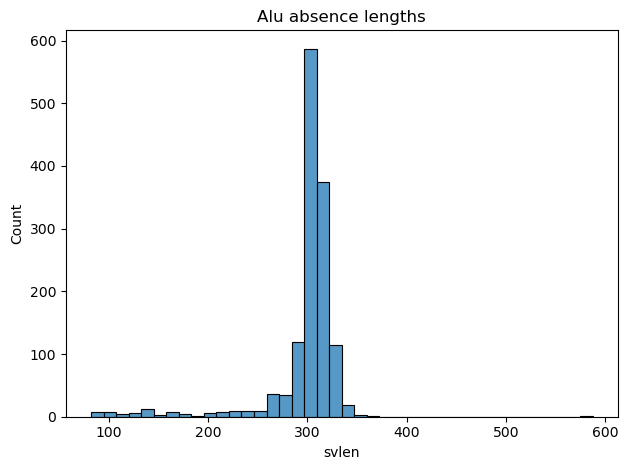

In [32]:
sns.histplot(data=abs_df, x='svlen', bins=40);
plt.title(f'{me_type} absence lengths')
plt.tight_layout()

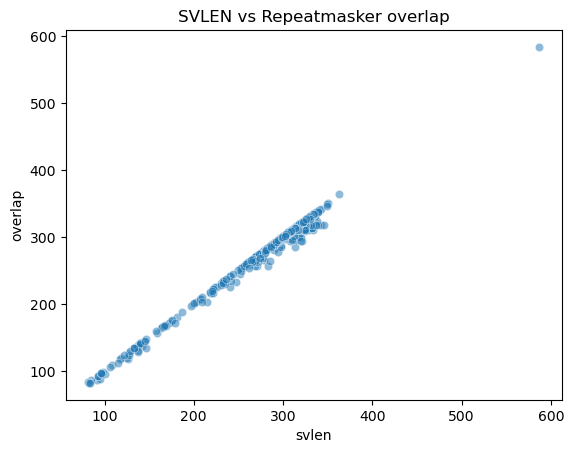

In [33]:
sns.scatterplot(data=abs_df, x='svlen', y='overlap', alpha=0.5)
plt.title('SVLEN vs Repeatmasker overlap');

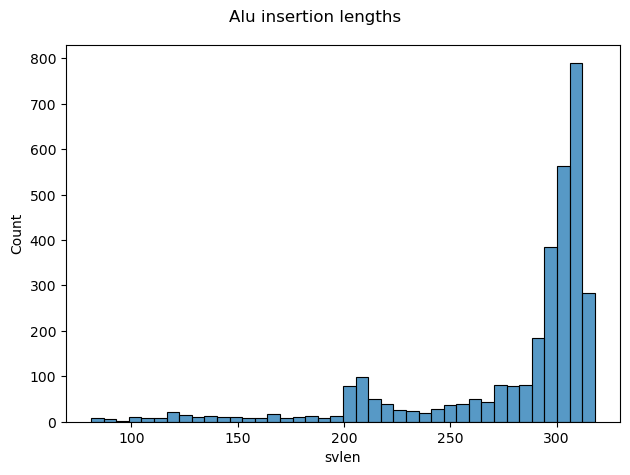

In [34]:
sns.histplot(data=ins_df, x='svlen', bins=40);
plt.suptitle(f'{me_type} insertion lengths')
plt.tight_layout()

## Export data

In [60]:
abs_out = abs_df[['chrom','start','end','id','svlen','strand','mei',
                  'het','alt']].reset_index(drop=True)
ins_out = ins_df[['chrom','start','end','id','svlen','strand','mei',
                  'het','alt']].reset_index(drop=True)

In [61]:
# Calculate number of high-quality variants per individual
num_abs_qc = parse_vcf.get_num_vars_per_donor(samples, abs_out, 'abs')
num_ins_qc = parse_vcf.get_num_vars_per_donor(samples, ins_out, 'ins')
num_vars_qc = pd.concat([num_abs_qc, num_ins_qc])
num_vars_qc['Filter'] = 'High-quality'

In [62]:
vars_per_donor = pd.concat([num_vars_raw, num_vars_qc])
vars_per_donor.to_csv(f'{outdir}/{me_type}_vars_per_donor.csv', index=True, header=True)

In [63]:
# Calculate number of donors per high-quality variant
num_donors_qc_abs = parse_vcf.get_num_donors_per_var(abs_df, 'abs')
num_donors_qc_ins = parse_vcf.get_num_donors_per_var(ins_df, 'ins')
num_donors_qc = pd.concat([num_donors_qc_abs, num_donors_qc_ins])
num_donors_qc['Filter'] = 'High-quality'

In [64]:
donors_per_var = pd.concat([num_donors_raw, num_donors_qc])
donors_per_var.to_csv(f'{outdir}/{me_type}_donors_per_var.csv', index=False, header=True)

In [65]:
# Write high-quality variants to file
# TODO: Determine whether to write header or not
abs_out['strand'] = abs_out['strand'].str.replace('C', '-')
abs_out.to_csv(f'{outdir}/all_{me_type}_abs.tsv', sep='\t', header=None, index=False)
ins_out.to_csv(f'{outdir}/all_{me_type}_ins.tsv', sep='\t', header=None, index=False)

In [66]:
# Write polymorphic reference elements to file
rmsk_out = abs_df['me_name']
poly_file = f'{outdir}/polymorphic_ref{me_type}.txt'
rmsk_out.to_csv(poly_file, sep='\t', header=None, index=False)

In [67]:
# Write non-polymorphic reference elements to file
# !grep -v -f {poly_file} {rmsk_bed} > {outdir}/non-polymorphic_ref{me_type}.bed